In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mat500 = np.load('../np/large_mat_res500x500.npy')

# 200x200 has speed-related advantages, sacrificing the smoothness of the rolling trajectory
mat200 = np.load('../np/large_mat_res200x200.npy')

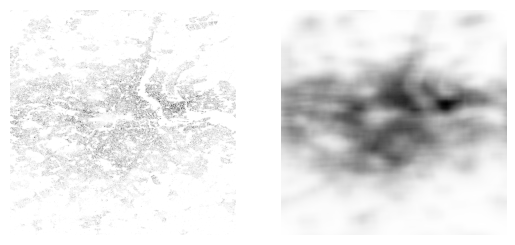

In [33]:
def smooth(mat, extent=2):
    matsize = mat.shape[0]
    smoothed_mat = np.copy(mat)
    for i in range(matsize):
        for j in range(matsize):
            idx_row = np.r_[i - extent : i + extent + 1] % matsize
            idx_col = np.r_[j - extent : j + extent + 1] % matsize
            smoothed_mat[i, j] = np.mean(smoothed_mat[np.ix_(idx_row, idx_col)])
    return smoothed_mat

def comp_assign(mat, deg=2):
    smoothed_mat = smooth(mat, deg)

    fig, ax = plt.subplots(1, 2)
    matrices = [mat, smoothed_mat]
    for i in range(2):
        ax[i].imshow(matrices[i], cmap='Greys')
        ax[i].axis('off')
    plt.savefig(f'../plots/extent{deg}_comp.png')
    plt.show()

    return smoothed_mat

sm500 = comp_assign(mat500, deg=20)

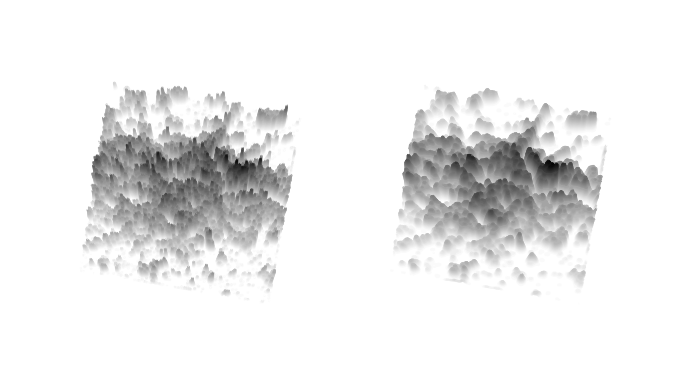

In [31]:
# Demonstration of the effect of smoothing on "rollability"

def comp_smoothed_3d(mat, n=1, surface=False, view_angle=(80, 100)):
    size = mat.shape[0]
    x = y = np.arange(size)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(12, 12))
    ax = {}
    for i in range(1, n+1):
        Z = smooth(mat, i**2)
        ax[i] = fig.add_subplot(1, 4, i, projection='3d')

        # Plot a surface plot with solid colors, else a contour plot of lines
        if surface:
            ax[i].plot_surface(-X, Y, Z, rstride=1, cstride=1, cmap='Greys', linewidth=0, antialiased=False)
        else:
            ax[i].contour3D(-X, Y, Z, 50, cmap='binary')
        ax[i].view_init(*view_angle)
        plt.axis('off')

    # Force subplots together
    fig.tight_layout(pad=-3)
    plt.savefig("../plots/comp_smooth_vs_none.png")
    plt.show()


comp_smoothed_3d(mat500, n=2)

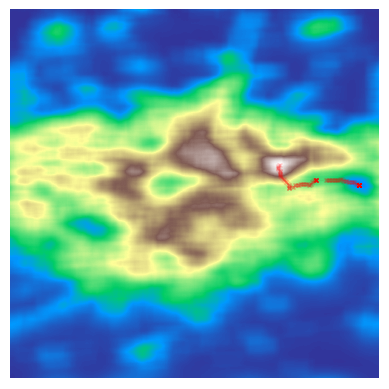

In [27]:
# Descent algorithm / 2d plot showing trajectory from highest point

def next_idx(mat, current_idx, window_size=1):
    # Find window around current point in matrix form
    i, j = current_idx
    idx_row = np.r_[i - window_size : i + window_size + 1]
    idx_col = np.r_[j - window_size : j + window_size + 1]
    window = mat[np.ix_(idx_row, idx_col)]

    # Find and restructure index of minimum point in window
    argmin = np.argmin(window)
    x, y = np.unravel_index(argmin, (window_size*2 + 1, window_size*2 + 1))
    return (x + i - window_size, y + j - window_size)


def simulate_descent(mat, old_idx):
    ids_list = [old_idx]

    # Loop through window sizes in case marble is stuck
    window_sizes = [i for i in range(1, 20)]
    for _ in range(1, 300):
        for size in window_sizes:
            new_idx = next_idx(mat, old_idx, size)

            # Stop if minimum is reached
            if mat[new_idx] == 0:
                return ids_list
            
            ids_list.append(new_idx)
            diff = mat[*old_idx] - mat[*new_idx]
            old_idx = new_idx

            # If marble isn't stuck, don't try other window sizes
            if diff > 0:
                break
    return ids_list


def buffer(mat, deg=100):
    buffd_mat = np.copy(mat)

    # Custom padding function
    def pad_with(vector, pad_width, _, kwargs):
        pad_value = kwargs.get('padder', 10)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value
    return np.pad(buffd_mat, deg, pad_with, padder=float('inf'))


def plot_descent_2d(mat, start_idx):
    buffd_mat = buffer(mat)

    # Indices of all points visited
    ids_list = simulate_descent(buffd_mat, start_idx)
    x, y = zip(*ids_list)
    plt.imshow(buffd_mat, origin='lower', cmap='terrain')
    plt.plot(y, x, '-x', markersize=3, linewidth=0.2, alpha=0.15, c='r')
    plt.axis('off')

    # Exclude infinity buffer in plot
    half_matsize = mat.shape[0] / 2
    plt.xlim(350 - half_matsize, 350 + half_matsize)
    plt.ylim(350 + half_matsize, 350 - half_matsize)
    plt.savefig('../plots/red_marker_terrain_2d.png')
    plt.show()

def def_start_idx(mat, offset=(0, 0), deg=100):
    start_idx = np.unravel_index(np.argmax(mat), mat.shape)

    # Adjustment for buffer size and desired offset from maximum
    return start_idx[0] + offset[0] + deg, start_idx[1] + offset[1] + deg

start_idx = def_start_idx(sm500)
plot_descent_2d(sm500, start_idx)


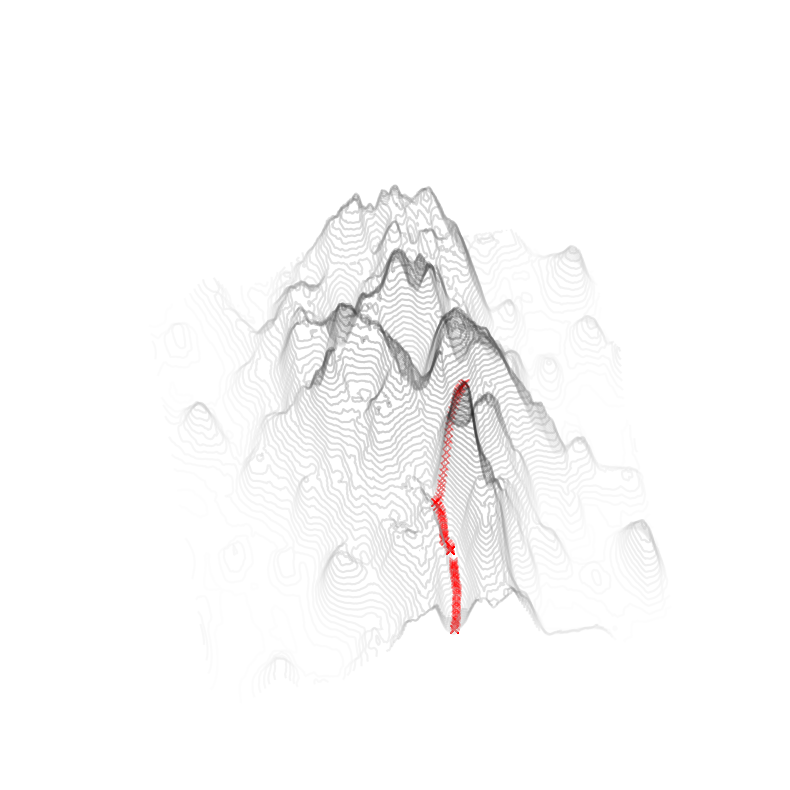

In [28]:
def descent_3d(mat, start_idx):
    
    # Matrices for 3d contour plots
    Z = buffer(mat)
    side_length = Z.shape[0]
    x_ids = y_ids = np.arange(side_length)
    X, Y = np.meshgrid(x_ids, y_ids)

    # Arrays for 3d line plots of trajectory
    ids_list = simulate_descent(Z, start_idx)
    z_list = [Z[x_i, y_i] for x_i, y_i in ids_list]
    x_list, y_list = zip(*ids_list)
    x, y, z = np.asarray(x_list), np.asarray(y_list), np.asarray(z_list)

    return x, y, z, X, Y, Z


def plot_descent_3d(mat, start_idx, angle=(80, 90)):
    x, y, z, X, Y, Z = descent_3d(mat, start_idx)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.contour3D(-X, Y, Z, 50, cmap='binary', alpha=0.3)
    ax.plot3D(-y, x, z, '-x', markersize=6, linewidth=0.2, alpha=0.5, c='r')

    # Custom view angle
    ax.view_init(*angle)

    # Exclude infinity buffer in plot
    half_matsize = mat.shape[0] / 2
    plt.xlim(-350 - half_matsize, -350 + half_matsize)
    plt.ylim(350 - half_matsize, 350 + half_matsize)
    plt.axis('off')
    plt.savefig("../plots/red_marker_mat500_3d.png")
    plt.show

plot_descent_3d(sm500, start_idx, angle=(60, 170))